---
title: "Palmer Penguins Modeling 8.1"
format: 
  html:
    embed-resources: true
execute:
  echo: true
code-fold: true
author: James Compagno
jupyter: python3
---

Import the Palmer Penguins dataset and print out the first few rows.

Suppose we want to predict `bill_depth_mm` using the other variables in the dataset.

**Dummify** all variables that require this.

In [5]:
import numpy as np
import pandas as pd
from palmerpenguins import load_penguins
import plotnine as p9
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.linear_model import ElasticNet, Lasso, LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeRegressor

/opt/anaconda3/lib/python3.13/site-packages/palmerpenguins/penguins.py:2: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [6]:
# Read the data
penguins = load_penguins()
penguins = penguins.dropna()

# Separate X and Y
y = penguins['bill_depth_mm']
X = penguins.drop(columns=['bill_depth_mm'])

# Train/test split on
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=67)

# Model Library 
model_library = {}
records = []

In [7]:
# Column Transformer with both scaling and encoding
ct = ColumnTransformer(
    [
        ("standardize", 
         StandardScaler(), 
         make_column_selector(dtype_include=np.number)),
        ("encode",
         OneHotEncoder(drop='first', sparse_output=False),
         make_column_selector(dtype_include=object))
    ],
    verbose_feature_names_out=False,
).set_output(transform="pandas")

Let's use the other variables to predict `bill_depth_mm`. Prepare your data and fit the following models on the entire dataset:

* Your best multiple linear regression model from before
* Two kNN models (for different values of K)
* A decision tree model

Create a plot like the right plot of Fig 1. in our `Model Validation` chapter with the training and test error plotted for each of your four models.

Which of your models was best?

# Best Multiple Linear Regression

In [8]:
def run_linear_regression(model_name, features=None):
    """
    model_name - will be stored in model_library example: "Linear_All"
    features - list or None - Example: ['bill_length_mm', 'flipper_length_mm']
    Hyperparameter_x_Name - name of hyperparameter (optional) - Example: Alpha 
    """
    regression_type = "Linear"
    
    # Select features
    if features is not None:
        X_train_subset = X_train[features]
        X_test_subset = X_test[features]
    else:
        X_train_subset = X_train
        X_test_subset = X_test
    
    # Cross Validation Pipeline
    pipe = Pipeline([
        ("preprocess", ct),
        ("linear_regression", LinearRegression())
    ])
    
    # Fit and add to Library
    pipe.fit(X_train_subset, y_train)
    model_library[model_name] = pipe
    
    # # Get top 10 coefficients
    # feature_names = pipe.named_steps['preprocess'].get_feature_names_out()
    # coefficients = pipe.named_steps['linear_regression'].coef_
    
    # coef_df = pd.DataFrame({
    #     'Variable': feature_names,
    #     'Coefficient': coefficients
    # }).sort_values('Coefficient', key=abs, ascending=False).head(10)
    
    # Metrics Calculatio
    rmse = cross_val_score(pipe, X_train_subset, y_train, cv=5, scoring='neg_root_mean_squared_error')
    mse = cross_val_score(pipe, X_train_subset, y_train, cv=5, scoring='neg_mean_squared_error')
    r2 = cross_val_score(pipe, X_train_subset, y_train, cv=5, scoring='r2')
    
    # Test Set Performance
    y_pred_test = pipe.predict(X_test_subset)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    test_mse = mean_squared_error(y_test, y_pred_test)
    test_r2 = r2_score(y_test, y_pred_test)
    
    # Metrics Storage 
    records.append({
        "Model": model_name,
        "Regression Type": regression_type,
        "Variables Used": len(X_train_subset.columns) if features else "All",
        "Hyperparameter 1 Name": "NA", 
        "Hyperparameter 1 Value": "NA",
        "Hyperparameter 2 Name": "NA", 
        "Hyperparameter 2 Value": "NA",
        # "Top 10 Variables": ", ".join(coef_df['Variable'].head(10).tolist()),
        # "Top 10 Coefficients": ", ".join([f"{c:.2f}" for c in coef_df['Coefficient'].head(10).tolist()]),
        "Split": "CV-5",
        "RMSE Mean": -rmse.mean(),
        "MSE Mean": -mse.mean(),
        "R2 Mean": r2.mean(),
        "Test RMSE": test_rmse,
        "Test MSE": test_mse,
        "Test R2": test_r2
    })
    
    return

In [9]:
run_linear_regression("All_Features_Linear", None)
pd.DataFrame(records)

,Model,Regression Type,Variables Used,Hyperparameter 1 Name,Hyperparameter 1 Value,Hyperparameter 2 Name,Hyperparameter 2 Value,Split,RMSE Mean,MSE Mean,R2 Mean,Test RMSE,Test MSE,Test R2
0,All_Features_Linear,Linear,All,NA,NA,NA,NA,CV-5,0.800739,0.646548,0.825812,0.784498,0.615436,0.846781


# kNN Models

In [10]:
def run_knn_regression(model_name, k_value, features=None):
    """
    model_name - will be stored in model_library example: "KNN_All_5"
    k_value - number of neighbors - Example: 5, 10, 15
    features - list or None - Example: ['bill_length_mm', 'flipper_length_mm']
    
    Returns: DataFrame 
    """
    
    # Select features
    if features is not None:
        X_train_subset = X_train[features]
        X_test_subset = X_test[features]
    else:
        X_train_subset = X_train
        X_test_subset = X_test
    
    # Pipeline with KNN
    pipe = Pipeline([
        ("preprocess", ct),
        ("knn", KNeighborsRegressor(n_neighbors=k_value))
    ])
    
    # Fit and add to Library
    pipe.fit(X_train_subset, y_train)
    model_library[model_name] = pipe
    
    # Metrics Calculation - Training (CV)
    rmse = cross_val_score(pipe, X_train_subset, y_train, cv=5, scoring='neg_root_mean_squared_error')
    mse = cross_val_score(pipe, X_train_subset, y_train, cv=5, scoring='neg_mean_squared_error')
    r2 = cross_val_score(pipe, X_train_subset, y_train, cv=5, scoring='r2')
    
    # Test Set Performance
    y_pred_test = pipe.predict(X_test_subset)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    test_mse = mean_squared_error(y_test, y_pred_test)
    test_r2 = r2_score(y_test, y_pred_test)
    
    # Metrics Storage 
    records.append({
        "Model": model_name,
        "Regression Type": "KNN",
        "Variables Used": len(X_train_subset.columns) if features else "All",
        "Hyperparameter 1 Name": "K (n_neighbors)", 
        "Hyperparameter 1 Value": k_value,
        "Hyperparameter 2 Name": "NA", 
        "Hyperparameter 2 Value": "NA",
        # "Top 10 Variables": "NA",
        # "Top 10 Coefficients": "NA",
        "Split": "CV-5",
        "RMSE Mean": -rmse.mean(),
        "MSE Mean": -mse.mean(),
        "R2 Mean": r2.mean(),
        "Test RMSE": test_rmse,
        "Test MSE": test_mse,
        "Test R2": test_r2
    })

In [11]:
run_knn_regression("KNN_All_5", 5)
pd.DataFrame(records)

,Model,Regression Type,Variables Used,Hyperparameter 1 Name,Hyperparameter 1 Value,Hyperparameter 2 Name,Hyperparameter 2 Value,Split,RMSE Mean,MSE Mean,R2 Mean,Test RMSE,Test MSE,Test R2
0,All_Features_Linear,Linear,All,NA,NA,NA,NA,CV-5,0.800739,0.646548,0.825812,0.784498,0.615436,0.846781
1,KNN_All_5,KNN,All,K (n_neighbors),5,NA,NA,CV-5,0.803467,0.652689,0.824707,0.872735,0.761666,0.810375


In [12]:
run_knn_regression("KNN_All_10", 10)
pd.DataFrame(records)

,Model,Regression Type,Variables Used,Hyperparameter 1 Name,Hyperparameter 1 Value,Hyperparameter 2 Name,Hyperparameter 2 Value,Split,RMSE Mean,MSE Mean,R2 Mean,Test RMSE,Test MSE,Test R2
0,All_Features_Linear,Linear,All,NA,NA,NA,NA,CV-5,0.800739,0.646548,0.825812,0.784498,0.615436,0.846781
1,KNN_All_5,KNN,All,K (n_neighbors),5,NA,NA,CV-5,0.803467,0.652689,0.824707,0.872735,0.761666,0.810375
2,KNN_All_10,KNN,All,K (n_neighbors),10,NA,NA,CV-5,0.823199,0.691619,0.812613,0.800219,0.640351,0.840578


# Decision Tree

In [13]:
def run_decision_tree_regression(model_name, max_depth, features=None):
    """
    model_name - will be stored in model_library example: "DecisionTree_MaxDepth_5"
    max_depth - maximum depth of the tree - Example: 3, 5, 10
    features - list or None - Example: ['bill_length_mm', 'flipper_length_mm']
    
    Returns: DataFrame 
    """
    
    # Select features
    if features is not None:
        X_train_subset = X_train[features]
        X_test_subset = X_test[features]
    else:
        X_train_subset = X_train
        X_test_subset = X_test
    
    # Pipeline with Decision Tree
    pipe = Pipeline([
        ("preprocess", ct),
        ("decision_tree", DecisionTreeRegressor(max_depth=max_depth, random_state=67))
    ])
    
    # Fit and add to Library
    pipe.fit(X_train_subset, y_train)
    model_library[model_name] = pipe
    
    # # Get feature importances (Decision Trees have this instead of coefficients)
    # feature_names = pipe.named_steps['preprocess'].get_feature_names_out()
    # importances = pipe.named_steps['decision_tree'].feature_importances_
    
    # importance_df = pd.DataFrame({
    #     'Variable': feature_names,
    #     'Importance': importances
    # }).sort_values('Importance', ascending=False).head(10)
    
    # # Store feature importances in model library
    # model_library[f"{model_name}_importances"] = importance_df
    
    # Metrics Calculation - Training (CV)
    rmse = cross_val_score(pipe, X_train_subset, y_train, cv=5, scoring='neg_root_mean_squared_error')
    mse = cross_val_score(pipe, X_train_subset, y_train, cv=5, scoring='neg_mean_squared_error')
    r2 = cross_val_score(pipe, X_train_subset, y_train, cv=5, scoring='r2')
    
    # Test Set Performance
    y_pred_test = pipe.predict(X_test_subset)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    test_mse = mean_squared_error(y_test, y_pred_test)
    test_r2 = r2_score(y_test, y_pred_test)
    
    # Metrics Storage 
    records.append({
        "Model": model_name,
        "Regression Type": "Decision Tree",
        "Variables Used": len(X_train_subset.columns) if features else "All",
        "Hyperparameter 1 Name": "Max Depth", 
        "Hyperparameter 1 Value": max_depth,
        "Hyperparameter 2 Name": "NA", 
        "Hyperparameter 2 Value": "NA",
        # "Top 10 Variables": ", ".join(importance_df['Variable'].head(10).tolist()),
        # "Top 10 Importances": ", ".join([f"{imp:.4f}" for imp in importance_df['Importance'].head(10).tolist()]),
        "Split": "CV-5",
        "RMSE Mean": -rmse.mean(),
        "MSE Mean": -mse.mean(),
        "R2 Mean": r2.mean(),
        "Test RMSE": test_rmse,
        "Test MSE": test_mse,
        "Test R2": test_r2
    })
    
    # Display
    return

In [14]:
run_decision_tree_regression("DecisionTree_MaxDepth_5", 5)
pd.DataFrame(records)

,Model,Regression Type,Variables Used,Hyperparameter 1 Name,Hyperparameter 1 Value,Hyperparameter 2 Name,Hyperparameter 2 Value,Split,RMSE Mean,MSE Mean,R2 Mean,Test RMSE,Test MSE,Test R2
0,All_Features_Linear,Linear,All,NA,NA,NA,NA,CV-5,0.800739,0.646548,0.825812,0.784498,0.615436,0.846781
1,KNN_All_5,KNN,All,K (n_neighbors),5,NA,NA,CV-5,0.803467,0.652689,0.824707,0.872735,0.761666,0.810375
2,KNN_All_10,KNN,All,K (n_neighbors),10,NA,NA,CV-5,0.823199,0.691619,0.812613,0.800219,0.640351,0.840578
3,DecisionTree_MaxDepth_5,Decision Tree,All,Max Depth,5,NA,NA,CV-5,0.961887,0.926928,0.748887,0.923782,0.853373,0.787544


# Best Model

In [15]:
pd.DataFrame(records).sort_values('MSE Mean', ascending=True).head(1) 

,Model,Regression Type,Variables Used,Hyperparameter 1 Name,Hyperparameter 1 Value,Hyperparameter 2 Name,Hyperparameter 2 Value,Split,RMSE Mean,MSE Mean,R2 Mean,Test RMSE,Test MSE,Test R2
0,All_Features_Linear,Linear,All,NA,NA,NA,NA,CV-5,0.800739,0.646548,0.825812,0.784498,0.615436,0.846781


In [16]:
# Prepare data for plotting
plot_data = []
for record in records:
    # Training data
    plot_data.append({
        'Model': record['Model'],
        'MSE': record['MSE Mean'],
        'Split': 'Training (CV-5)'
    })
    # Test data
    plot_data.append({
        'Model': record['Model'],
        'MSE': record['Test MSE'],
        'Split': 'Test'
    })

plot_df = pd.DataFrame(plot_data)

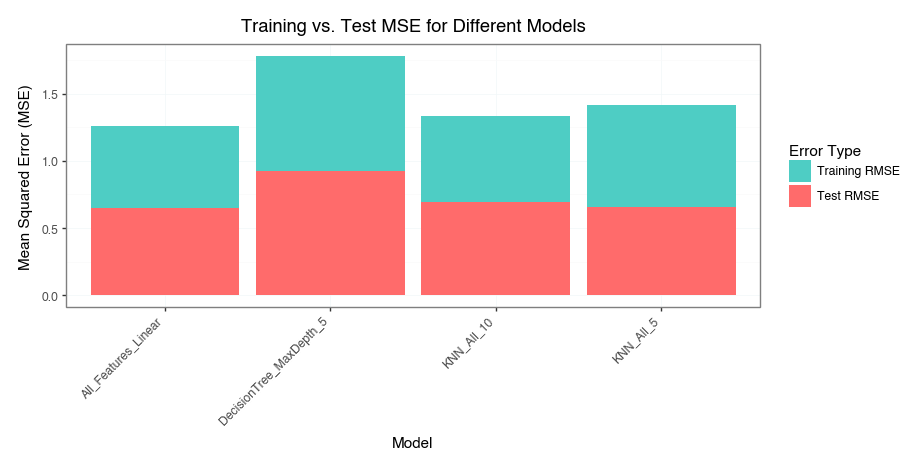

In [17]:
# Create plot
(p9.ggplot(plot_df,
    p9.aes(
        x = "Model",
        y = "MSE",
        fill = "Split"
    ))
    + p9.geom_col(position = "stack")
    + p9.labs(
        title = "Training vs. Test MSE for Different Models",
        x = "Model",
        y = "Mean Squared Error (MSE)",
        fill = "Error Type"
    )
    + p9.theme_bw()
    + p9.theme(
        figure_size = (9, 4.5),
        panel_background = p9.element_rect(fill = "white"),
        panel_grid_major = p9.element_line(color = "#f2f7f8", size = 0.5),
        axis_text_x = p9.element_text(rotation = 45, ha = "right")
    )
    + p9.scale_fill_manual(values = ["#4ECDC4", "#FF6B6B"], labels = ["Training RMSE", "Test RMSE"])
)